# Example Experiment
> Experiment using Repeated MNIST and BatchBALD vs BALD vs random sampling

This notebook ties everything together and runs an AL loop.

In [2]:
%load_ext autoreload
%autoreload 2

# experiment

import numpy as np
import torch
from tqdm.auto import tqdm

SEED = 51505
STRATEGY = "batch_bald"

max_training_samples = 150  # TERMINATION CONDITION - i.e. STOP ACQUIRING ONCE WE HAVE THIS MANY
acquisition_batch_size = 5
num_inference_samples = 100  # MONTE CARLO DROPOUT ENSEMBLE SIZE FOR COMPUTING ENTROPIES...INTERESTING THAT IT'S SO LARGE
num_test_inference_samples = 5  # ENSEMBLE SIZE FOR SCORING ON TEST SET. TODO SEE IF MAKING THIS LARGE HELPS...
num_samples = 100000  
# FOR BATCH BALD JOINT ENTROPY COMPUTATION...TO REPLACE SUM OVER Y1...YM WITH UNIFORM SAMPLES AND USE IMPORTANCE SAMPLING.  THIS IS WHY IT'S SLOW

test_batch_size = 512
batch_size = 64
scoring_batch_size = 128
training_iterations = 4096 * 6


assert STRATEGY in ["batch_bald", "bald", "random"]

np.random.seed(SEED)
torch.manual_seed(SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# experiment

import math

import torch
from torch import nn as nn
from torch.nn import functional as F

from batchbald_redux import (
    active_learning,
    batchbald,
    consistent_mc_dropout,
    joint_entropy,
    repeated_mnist,
)

Let's define our Bayesian CNN model that we will use to train MNIST.

In [4]:
# experiment


class BayesianCNN(consistent_mc_dropout.BayesianModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv1_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.fc1 = nn.Linear(1024, 128)
        self.fc1_drop = consistent_mc_dropout.ConsistentMCDropout()
        self.fc2 = nn.Linear(128, num_classes)

    def mc_forward_impl(self, input: torch.Tensor):
        input = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(input)), 2))
        input = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(input)), 2))
        input = input.view(-1, 1024)
        input = F.relu(self.fc1_drop(self.fc1(input)))
        input = self.fc2(input)
        input = F.log_softmax(input, dim=1)

        return input

Grab our dataset, we'll use Repeated-MNIST. We will acquire to samples for each class for our initial training set.

N.B. with num repetitions=1, we just have the standard MNIST dataset

In [19]:
# experiment
g = torch.Generator().manual_seed(SEED)
train_dataset, test_dataset = repeated_mnist.create_repeated_MNIST_dataset(num_repetitions=1, add_noise=False)

num_initial_samples = 20
num_classes = 10

initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset),
    num_classes=num_classes,
    n_per_digit=num_initial_samples / num_classes,
    generator=g,
)
initial_samples

tensor([42166, 38358, 10065,  ..., 22016, 19696, 14168])


[42166,
 38358,
 10065,
 48041,
 17784,
 50417,
 24155,
 40706,
 5445,
 41228,
 49514,
 33271,
 48070,
 52203,
 41623,
 1433,
 53689,
 3449,
 47520,
 9544]

In [20]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

For this example, we are going to take two shortcuts that will reduce the performance:
* we discard most of the training set and only keep 20k samples; and
* we don't implement early stopping or epoch-wise training.

Instead, we always train by drawing 24576 many samples from the training set. This will overfit in the beginning and underfit later, but it still is sufficient to achieve 90% accuracy with 105 samples in the training set. 

In [21]:
# experiment

use_cuda = torch.cuda.is_available()

print(f"use_cuda: {use_cuda}")

device = "cuda" if use_cuda else "cpu"

kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(40000)

train_loader = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(
    active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
)

# Run experiment
test_accs = []
test_loss = []
added_indices = []

pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")

while True:
    model = BayesianCNN(num_classes).to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = model(data, 1).squeeze(1)
        loss = F.nll_loss(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = torch.logsumexp(model(data, num_test_inference_samples), dim=1) - math.log(
                num_test_inference_samples
            )
            loss += F.nll_loss(prediction, target, reduction="sum")

            prediction = prediction.max(1)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire pool predictions
    N = len(active_learning_data.pool_dataset)
    
    if STRATEGY in ["batch_bald", "bald"]:
        logits_N_K_C = torch.empty((N, num_inference_samples, num_classes), dtype=torch.double, pin_memory=use_cuda)

        with torch.no_grad():
            model.eval()

            for i, (data, _) in enumerate(tqdm(pool_loader, desc="Evaluating Acquisition Set", leave=False)):
                data = data.to(device=device)

                lower = i * pool_loader.batch_size
                upper = min(lower + pool_loader.batch_size, N)
                logits_N_K_C[lower:upper].copy_(model(data, num_inference_samples).double(), non_blocking=True)

        if STRATEGY == "batch_bald":
            with torch.no_grad():
                candidate_batch = batchbald.get_batchbald_batch(
                    logits_N_K_C, acquisition_batch_size, num_samples, dtype=torch.double, device=device
                )
        elif STRATEGY == "bald":
            with torch.no_grad():
                candidate_batch = batchbald.get_bald_batch(
                    logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device
                )
    elif STRATEGY == "random":
        candidate_batch = batchbald.get_random_batch(N, acquistion_batch_size)
    else:
        raise ValueError(STRATEGY)

    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    pbar.update(len(dataset_indices))

use_cuda: False


Training Set Size:  13%|#3        | 20/150 [00:00<?, ?it/s]

Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.9851, Accuracy: 6187/10000 (61.87%)


Evaluating Acquisition Set:   0%|          | 0/157 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19980 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19980 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19980 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19980 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19980 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19980 [00:00<?, ?it/s]

Dataset indices:  [18726 34558 34758  5982 48112]
Scores:  [1.4329846533152113, 2.5485550244682833, 3.4058368765910707, 3.9405685312837595, 4.2392834155109576]
Labels:  tensor([4, 2, 8, 4, 1])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 2.0696, Accuracy: 6710/10000 (67.10%)


Evaluating Acquisition Set:   0%|          | 0/157 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19975 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19975 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19975 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19975 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19975 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19975 [00:00<?, ?it/s]

Dataset indices:  [27174 26411 18501 15254 32977]
Scores:  [1.279695434846921, 2.4206707663768885, 3.2698494391286217, 3.817803111287361, 4.163648844993003]
Labels:  tensor([9, 5, 4, 7, 6])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.3483, Accuracy: 7080/10000 (70.80%)


Evaluating Acquisition Set:   0%|          | 0/157 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19970 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19970 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19970 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19970 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19970 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19970 [00:00<?, ?it/s]

Dataset indices:  [22662 16708  5259 42112 17693]
Scores:  [1.208303284285325, 2.274694036604455, 3.107891643332643, 3.701025231907371, 4.084040515715893]
Labels:  tensor([7, 3, 2, 8, 0])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.5858, Accuracy: 7246/10000 (72.46%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19965 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19965 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19965 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19965 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19965 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19965 [00:00<?, ?it/s]

Dataset indices:  [48096 46580 36767 16095 29408]
Scores:  [1.2622116298471246, 2.3855691179452467, 3.2889863735911216, 3.8687839091250797, 4.213298988911589]
Labels:  tensor([7, 6, 7, 5, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 1.1270, Accuracy: 7605/10000 (76.05%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19960 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19960 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19960 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19960 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19960 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19960 [00:00<?, ?it/s]

Dataset indices:  [56233 53309 41537 17540 35801]
Scores:  [1.1945045553644, 2.267155944261601, 3.1290948215901033, 3.721524105733613, 4.11803669674255]
Labels:  tensor([7, 5, 3, 1, 3])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.9572, Accuracy: 7961/10000 (79.61%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19955 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19955 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19955 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19955 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19955 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19955 [00:00<?, ?it/s]

Dataset indices:  [40589 28951 22353 59622 30162]
Scores:  [1.2830983019938211, 2.375458540579733, 3.2397124229247023, 3.829349745009587, 4.179428200124944]
Labels:  tensor([2, 5, 2, 8, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.7343, Accuracy: 8130/10000 (81.30%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19950 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19950 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19950 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19950 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19950 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19950 [00:00<?, ?it/s]

Dataset indices:  [11852 11074 14290 12345 25566]
Scores:  [1.3018073693424643, 2.438956895905376, 3.286737824068082, 3.87096063086084, 4.209136140358176]
Labels:  tensor([4, 9, 4, 3, 5])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.6010, Accuracy: 8333/10000 (83.33%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19945 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19945 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19945 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19945 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19945 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19945 [00:00<?, ?it/s]

Dataset indices:  [24541 35903 50433 45732 51314]
Scores:  [1.1475014562691084, 2.1615471352965514, 3.0045103958960757, 3.6274079009999873, 4.047129935324348]
Labels:  tensor([0, 5, 4, 3, 0])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.6334, Accuracy: 8318/10000 (83.18%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19940 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19940 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19940 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19940 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19940 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19940 [00:00<?, ?it/s]

Dataset indices:  [51679 42632 26444 54994 14364]
Scores:  [1.1588768994150458, 2.2037831948288815, 3.091393997308799, 3.7243901087000166, 4.130431519706638]
Labels:  tensor([5, 0, 1, 6, 9])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.5145, Accuracy: 8589/10000 (85.89%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19935 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19935 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19935 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19935 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19935 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19935 [00:00<?, ?it/s]

Dataset indices:  [32421  8691 47146 38256 11154]
Scores:  [1.329400340295619, 2.5007162067852615, 3.383869338814202, 3.97870221368023, 4.295563933599852]
Labels:  tensor([3, 2, 5, 2, 5])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4810, Accuracy: 8622/10000 (86.22%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19930 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19930 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19930 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19930 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19930 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19930 [00:00<?, ?it/s]

Dataset indices:  [14394  1423 17079 40571 39487]
Scores:  [1.1691727884341991, 2.221798033672289, 3.0879174482688274, 3.712182989812341, 4.1144385665996115]
Labels:  tensor([3, 0, 6, 8, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4073, Accuracy: 8776/10000 (87.76%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19925 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19925 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19925 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19925 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19925 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19925 [00:00<?, ?it/s]

Dataset indices:  [58470   826  8867 16959 32269]
Scores:  [1.205375014087703, 2.257720201660068, 3.093991606225069, 3.714499193224952, 4.0771014666059475]
Labels:  tensor([9, 9, 8, 5, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4736, Accuracy: 8589/10000 (85.89%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19920 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19920 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19920 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19920 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19920 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19920 [00:00<?, ?it/s]

Dataset indices:  [ 3382 30296 38052 17521 20663]
Scores:  [1.167393737473112, 2.2143741485255872, 3.064675547879961, 3.680864017602116, 4.087607297883674]
Labels:  tensor([9, 9, 4, 3, 6])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3788, Accuracy: 8882/10000 (88.82%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19915 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19915 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19915 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19915 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19915 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19915 [00:00<?, ?it/s]

Dataset indices:  [45274 20328 33167 56468 16592]
Scores:  [1.112027682817001, 2.0705362371837, 2.920461708135372, 3.569251575228635, 3.990399490963105]
Labels:  tensor([6, 8, 6, 5, 5])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3696, Accuracy: 8951/10000 (89.51%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19910 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19910 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19910 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19910 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19910 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19910 [00:00<?, ?it/s]

Dataset indices:  [ 8045  2118 58812 21174 31301]
Scores:  [1.1492738508583895, 2.159815012292994, 3.00169117283448, 3.6221961029487195, 4.048263297999048]
Labels:  tensor([8, 7, 3, 2, 5])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.4028, Accuracy: 8847/10000 (88.47%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19905 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19905 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19905 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19905 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19905 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19905 [00:00<?, ?it/s]

Dataset indices:  [ 7833 28199 16692 20641 21880]
Scores:  [1.2036440332902962, 2.3078800904605288, 3.1424222412287053, 3.731499689004806, 4.101482530060923]
Labels:  tensor([5, 3, 5, 9, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3912, Accuracy: 8868/10000 (88.68%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19900 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19900 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19900 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19900 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19900 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19900 [00:00<?, ?it/s]

Dataset indices:  [ 9428 34520 43702 17420 26072]
Scores:  [1.0562095908052678, 2.0435476010506175, 2.8497990994121443, 3.476033071318637, 3.90934600074647]
Labels:  tensor([9, 6, 3, 7, 1])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3910, Accuracy: 8839/10000 (88.39%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19895 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19895 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19895 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19895 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19895 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19895 [00:00<?, ?it/s]

Dataset indices:  [43852  2548 40922 17592  4414]
Scores:  [1.097801335853177, 2.1096720444337835, 2.9333970993703864, 3.5771278369816484, 4.003031040206694]
Labels:  tensor([2, 4, 0, 4, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3631, Accuracy: 8890/10000 (88.90%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19890 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19890 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19890 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19890 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19890 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19890 [00:00<?, ?it/s]

Dataset indices:  [ 1075 45245 15450 41999 23782]
Scores:  [1.0672234455931395, 2.029503451198271, 2.829843050775981, 3.454985228886873, 3.910644012658304]
Labels:  tensor([7, 8, 6, 0, 7])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3597, Accuracy: 8923/10000 (89.23%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19885 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19885 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19885 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19885 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19885 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19885 [00:00<?, ?it/s]

Dataset indices:  [32747 44142 33340 52306  5315]
Scores:  [1.156603564155838, 2.12135877482648, 2.8925349079987193, 3.4905012144974377, 3.9030356012735368]
Labels:  tensor([8, 3, 5, 8, 3])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3559, Accuracy: 8973/10000 (89.73%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19880 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19880 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19880 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19880 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19880 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19880 [00:00<?, ?it/s]

Dataset indices:  [38577 28226 22503 18740 45048]
Scores:  [1.0832893021251109, 2.0994706732065977, 2.949440652807316, 3.5556221970321977, 3.9717644443302356]
Labels:  tensor([5, 8, 9, 8, 4])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3104, Accuracy: 9094/10000 (90.94%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19875 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19875 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19875 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19875 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19875 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19875 [00:00<?, ?it/s]

Dataset indices:  [22083  6428  5161 59726 19973]
Scores:  [1.0734412189631788, 2.083161130183917, 2.9055203426666583, 3.522273002113654, 3.9490182204099535]
Labels:  tensor([2, 3, 7, 5, 5])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3055, Accuracy: 9087/10000 (90.87%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19870 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19870 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19870 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19870 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19870 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19870 [00:00<?, ?it/s]

Dataset indices:  [59294 18473 12416  9778 38178]
Scores:  [1.015940937004237, 1.969284312451951, 2.7782390743581287, 3.422364136915783, 3.884725070798169]
Labels:  tensor([8, 4, 3, 3, 7])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3127, Accuracy: 9082/10000 (90.82%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19865 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19865 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19865 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19865 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19865 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19865 [00:00<?, ?it/s]

Dataset indices:  [  274 57728 44123 48726 28454]
Scores:  [1.1263531929870214, 2.0810052140594157, 2.877148562945016, 3.480234915029447, 3.9024852082402637]
Labels:  tensor([6, 9, 8, 8, 2])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3162, Accuracy: 9059/10000 (90.59%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19860 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19860 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19860 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19860 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19860 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19860 [00:00<?, ?it/s]

Dataset indices:  [14749 44624 57810  4165 25986]
Scores:  [0.9981375322402265, 1.8596543531953036, 2.6328528914327607, 3.279608034608723, 3.7538162354907474]
Labels:  tensor([0, 8, 0, 2, 8])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.3082, Accuracy: 9125/10000 (91.25%)


Evaluating Acquisition Set:   0%|          | 0/156 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/19855 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19855 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19855 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19855 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19855 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/19855 [00:00<?, ?it/s]

Dataset indices:  [ 6269 31184 31310  3273 20402]
Scores:  [1.1090731604535158, 2.051428685334037, 2.82566291493114, 3.4313328890716117, 3.85757605329363]
Labels:  tensor([3, 9, 0, 8, 9])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/20 [00:00<?, ?it/s]

Test set: Average loss: 0.2893, Accuracy: 9173/10000 (91.73%)


In [24]:
test_loss = torch.stack(test_loss).tolist()

TypeError: expected Tensor as element 0 in argument 0, but got float

In [25]:
np.savez("batchbald_51505", test_loss=test_loss, test_accs=test_accs, added_indices=added_indices)

In [35]:
rnd = np.load("rnd_51505.npz")
bald = np.load("bald_51505.npz")

In [29]:
rnd["test_accs"]

array([61.87, 65.74, 66.43, 71.68, 72.78, 71.47, 76.54, 75.37, 77.21,
       77.28, 81.85, 83.41, 83.26, 85.4 , 85.35, 85.55, 87.84, 88.48,
       88.59, 89.21, 89.2 , 89.56, 89.93, 90.23, 89.56, 90.34, 90.27])

Q. what explains the long run decay in advantage? Could it be non-iid sampling?

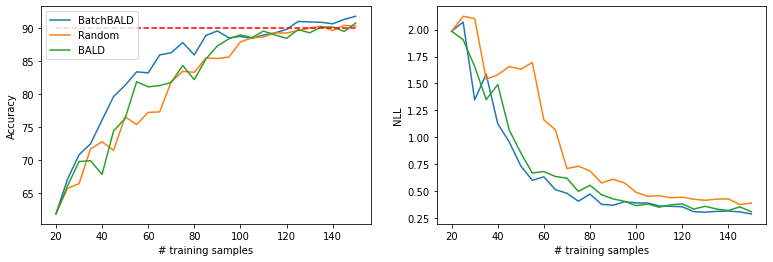

In [36]:
# experiment
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(13,4))
plt.subplot(121)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), test_accs, label="BatchBALD")
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), rnd["test_accs"], label="Random")
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), bald["test_accs"], label="BALD")

plt.xlabel("# training samples")
plt.ylabel("Accuracy")
plt.hlines(90, 20, 150, linestyles="dashed", color="r")
plt.legend()
plt.subplot(122)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), test_loss, label="BatchBALD")
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), rnd["test_loss"], label="Random")
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), bald["test_loss"], label="BALD")

plt.xlabel("# training samples")
plt.ylabel("NLL")
plt.show()
